Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_Jørgen_Strand_Larsen.png


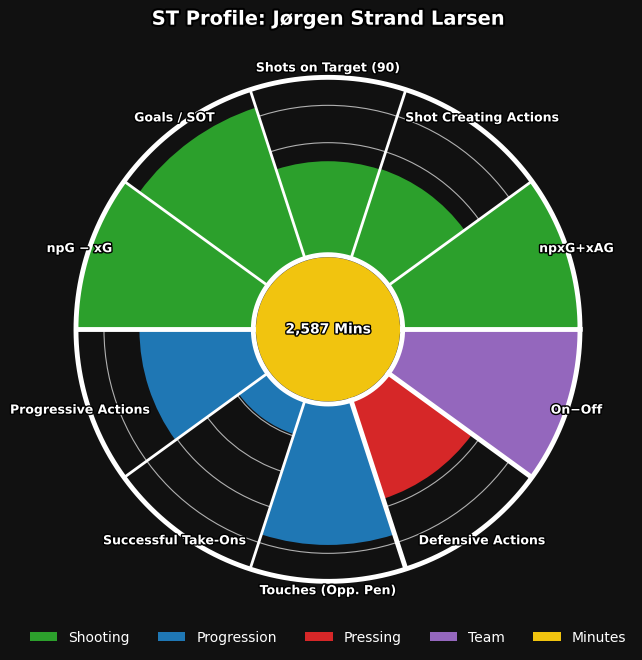

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_Sasa_Kalajdzic.png


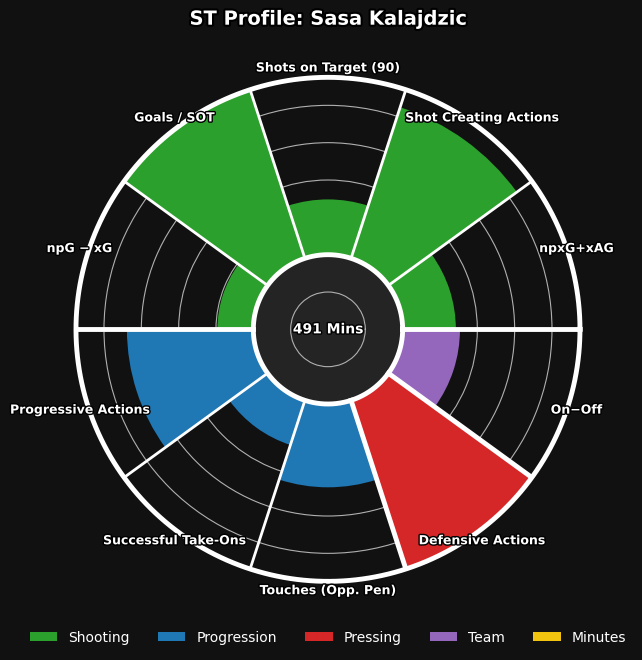

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_Fábio_Silva.png


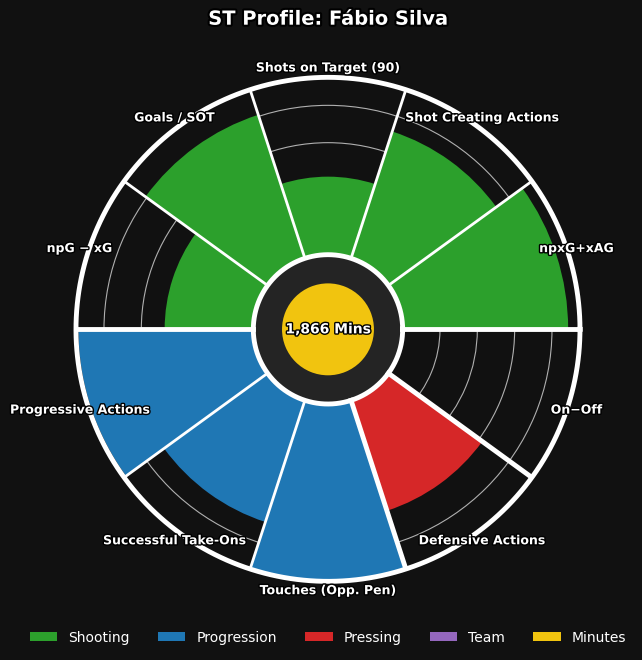

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_Mihailo_Ivanović.png


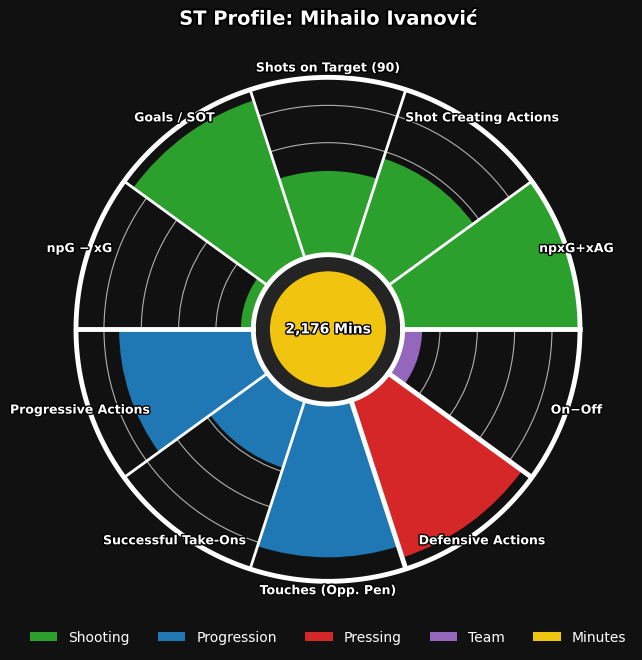

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_David_Datro_Fofana.png


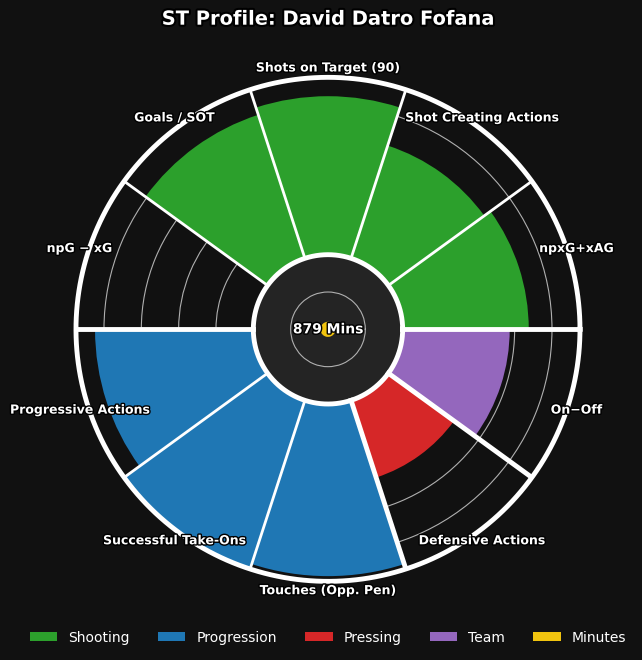

Saved: /Users/derekchui/Documents/Programming/Personal/Projects/Football Analytics/Project 2/Project 2.6/st_donuts_dark/donut_Christantus_Uche.png


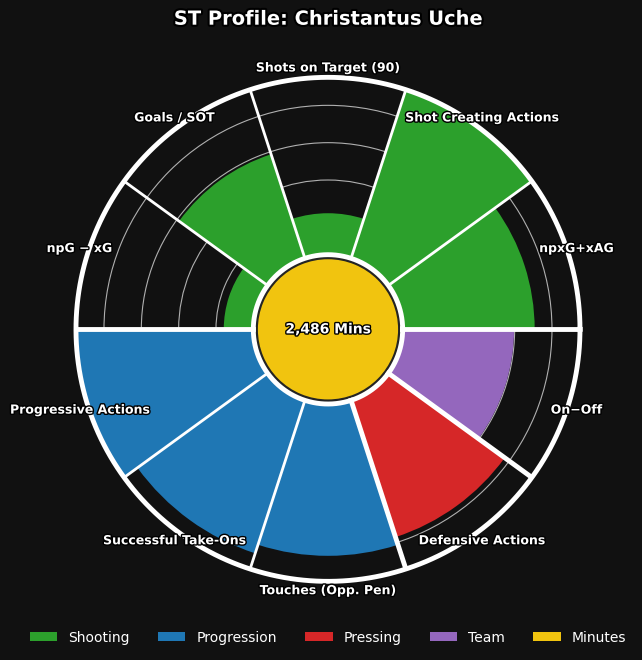

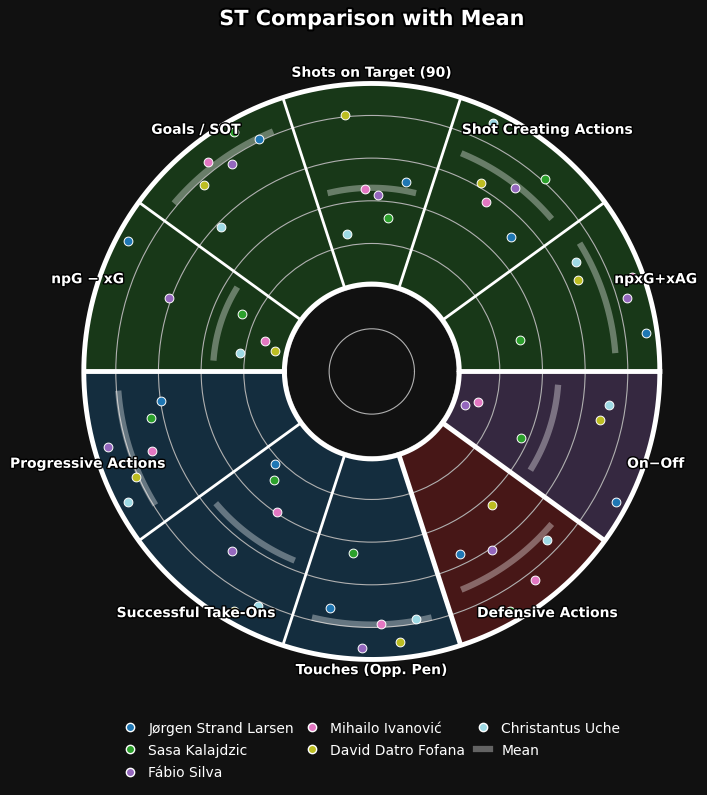

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from pathlib import Path
import matplotlib as mpl

SHOW_PLAYER_DONUTS   = True
PRINT_SAVE_MESSAGES  = True
OUTPUT_DIR           = Path("st_donuts_dark")
OUTPUT_DIR.mkdir(exist_ok=True)

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

VIS_MIN = 0.07       
FLOOR_ZEROES = False 

metrics = [
    'npxG+xAG', 'SCA', 'SOT90', 'GSOT', 'npG-xG',
    'PrgA', 'STO', 'TAP',
    'DA',
    'On-Off'
]

display_names = {
    'npxG+xAG': 'npxG+xAG',
    'SCA': 'Shot Creating Actions',
    'SOT90': 'Shots on Target (90)',
    'GSOT': 'Goals / SOT',
    'npG-xG': 'npG − xG',
    'PrgA': 'Progressive Actions',
    'STO': 'Successful Take-Ons',
    'TAP': 'Touches (Opp. Pen)',
    'DA': 'Defensive Actions',
    'On-Off': 'On−Off'
}

shooting   = ['npxG+xAG', 'SCA', 'SOT90', 'GSOT', 'npG-xG']
progress   = ['PrgA', 'STO', 'TAP']
pressing   = ['DA']
team       = ['On-Off']
category_order = shooting + progress + pressing + team

FIG_BG = AX_BG = "#111111"
SHOOT_COLOR = "#2ca02c"
PROG_COLOR  = "#1f77b4"
PRESS_COLOR = "#d62728"
TEAM_COLOR  = "#9467bd"

SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

MIN_BG_COLOR   = "#242424"
MIN_FILL_COLOR = "#f1c40f"
MIN_TEXT_COLOR = "white"

POS_FILTERS = ["ST", "CF", "FW"]
st_df = df[df["Position"].astype(str).str.upper().isin(POS_FILTERS)].copy()
if st_df.empty:
    print("Note: No rows with Position in", POS_FILTERS, "— using ALL rows instead.")
    st_df = df.copy()
players = [str(p).strip() for p in st_df["Player"].tolist()]

def safe_p90(series):
    s = pd.to_numeric(series, errors='coerce').dropna()
    if s.empty: return 1.0
    val = np.nanpercentile(s.values.astype(float), 90)
    return float(val) if val > 0 else 1.0

signed_metrics = ['npG-xG', 'On-Off']
nonneg_metrics = [m for m in metrics if m not in signed_metrics]
p90_map = {m: safe_p90(df[m]) if m in df.columns else 1.0 for m in nonneg_metrics}

def signed_bounds(name):
    if name not in df.columns: return (0.0,1.0,0.0,1.0)
    s = pd.to_numeric(df[name], errors='coerce').dropna()
    if s.empty: return (0.0,1.0,0.0,1.0)
    mn, mx = float(s.min()), float(s.max())
    rng_all = max(1e-9, mx-mn)
    lo, hi = float(s.quantile(0.10)), float(s.quantile(0.90))
    rng_q = max(1e-9, hi-lo)
    return (mn, rng_all, lo, rng_q)

npGxG_min_all, npGxG_rng_all, npGxG_lo, npGxG_rng = signed_bounds('npG-xG')
onoff_min_all, onoff_rng_all, onoff_lo, onoff_rng = signed_bounds('On-Off')

norm_df_player = st_df.copy()
for m in nonneg_metrics:
    if m in st_df.columns:
        denom = p90_map[m]
        norm_df_player[m] = (pd.to_numeric(st_df[m], errors='coerce')/denom).clip(0,1)
    else: norm_df_player[m] = 0.0
if 'npG-xG' in st_df.columns:
    norm_df_player['npG-xG'] = ((pd.to_numeric(st_df['npG-xG'], errors='coerce')-npGxG_min_all)/npGxG_rng_all).clip(0,1)
if 'On-Off' in st_df.columns:
    norm_df_player['On-Off'] = ((pd.to_numeric(st_df['On-Off'], errors='coerce')-onoff_min_all)/onoff_rng_all).clip(0,1)

norm_df_group = st_df.copy()
for m in nonneg_metrics:
    if m in st_df.columns:
        denom = p90_map[m]
        norm_df_group[m] = (pd.to_numeric(st_df[m], errors='coerce')/denom).clip(0,1)
    else: norm_df_group[m] = 0.0
if 'npG-xG' in st_df.columns:
    norm_df_group['npG-xG'] = ((pd.to_numeric(st_df['npG-xG'], errors='coerce')-npGxG_lo)/npGxG_rng).clip(0,1)
if 'On-Off' in st_df.columns:
    norm_df_group['On-Off'] = ((pd.to_numeric(st_df['On-Off'], errors='coerce')-onoff_lo)/onoff_rng).clip(0,1)

if 'Min' in st_df.columns:
    mins_series = pd.to_numeric(st_df['Min'], errors='coerce').dropna()
    min_lo = np.nanpercentile(mins_series, 10) if len(mins_series) else 0
    min_hi = np.nanpercentile(mins_series, 90) if len(mins_series) else 1
else: min_lo, min_hi = 0,1
min_rng = max(1e-9, min_hi-min_lo)

def minutes_fill_fraction(player_name):
    if 'Min' not in st_df.columns: return 0.0,"Mins Unavailable"
    row = st_df.loc[st_df['Player']==player_name,'Min']
    if row.empty or pd.isna(row.iloc[0]): return 0.0,"Mins Unavailable"
    mins = float(pd.to_numeric(row.iloc[0], errors='coerce'))
    frac = (mins-min_lo)/min_rng
    frac = np.clip(frac,0,1)
    return frac,f"{int(round(mins)):,} Mins"

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi/len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_shoot_end = len(shooting)
idx_prog_end  = len(shooting)+len(progress)
idx_press_end = len(shooting)+len(progress)+len(pressing)

def color_for_metric(m):
    if m in shooting: return SHOOT_COLOR
    if m in progress: return PROG_COLOR
    if m in pressing: return PRESS_COLOR
    return TEAM_COLOR

wedge_colors = [color_for_metric(m) for m in metrics]

for name in players:
    row = norm_df_player.loc[norm_df_player['Player']==name, metrics]
    if row.empty: continue
    vals = np.nan_to_num(row.values.flatten().astype(float), nan=0.0)
    if FLOOR_ZEROES:
        vals_plot = np.maximum(vals, VIS_MIN)
    else:
        vals_plot = np.where(vals>0, np.maximum(vals,VIS_MIN), 0.0)

    fig = plt.figure(figsize=(7,7)); fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111, polar=True); ax.set_facecolor(AX_BG); ax.set_ylim(0,outer_radius)
    inner_circle_radius_overlay = inner_radius+0.05; scale = outer_radius-inner_circle_radius_overlay

    ax.bar(0, inner_circle_radius_overlay, width=2*np.pi, bottom=0,
           color=MIN_BG_COLOR, zorder=1.5, align='edge', edgecolor=None)
    frac,mins_label = minutes_fill_fraction(name)
    r_fill = inner_circle_radius_overlay*(frac*0.965)
    ax.bar(0,r_fill,width=2*np.pi,bottom=0,color=MIN_FILL_COLOR,zorder=1.6,align='edge',edgecolor=None)
    txt_m=ax.text(0.5,0.50,mins_label,transform=ax.transAxes,ha='center',va='center',
                  fontsize=10,fontweight='bold',color=MIN_TEXT_COLOR,zorder=8)
    txt_m.set_path_effects([path_effects.Stroke(linewidth=2,foreground='black'),path_effects.Normal()])

    ax.bar(angles, vals_plot*scale, width=width, bottom=inner_circle_radius_overlay,
           align='edge', color=wedge_colors, zorder=2)
    ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])
    for ang in angles:
        ax.plot([ang,ang],[inner_circle_radius_overlay,outer_radius],linewidth=SEP_THIN,
                color=SEPARATOR_COLOR,zorder=3)
    for b_idx in [0,idx_shoot_end,idx_prog_end,idx_press_end]:
        ax.plot([angles[b_idx],angles[b_idx]],[inner_circle_radius_overlay,outer_radius],
                linewidth=SEP_THICK,color=SEPARATOR_COLOR,zorder=4)
    ax.plot(theta_circle,np.full_like(theta_circle,outer_radius),color=SEPARATOR_COLOR,
            linewidth=SEP_THICK,zorder=5,clip_on=False)

    for ang,lab in zip(angles+width/2,[display_names[m] for m in metrics]):
        txt=ax.text(ang,inner_radius+1.05,lab,ha='center',va='center',fontsize=9,
                    fontweight='bold',color='white',zorder=6)
        txt.set_path_effects([path_effects.Stroke(linewidth=2,foreground='black'),path_effects.Normal()])

    ax.plot(theta_circle,np.full_like(theta_circle,inner_circle_radius_overlay),
            color=SEPARATOR_COLOR,linewidth=SEP_THICK,zorder=10,clip_on=False)

    title=ax.set_title(f"ST Profile: {name}",va='bottom',y=1.08,
                       fontsize=14,fontweight='bold',color='white')
    title.set_path_effects([path_effects.Stroke(linewidth=3,foreground='black'),path_effects.Normal()])

    legend_handles=[Patch(facecolor=SHOOT_COLOR,label="Shooting"),
                    Patch(facecolor=PROG_COLOR,label="Progression"),
                    Patch(facecolor=PRESS_COLOR,label="Pressing"),
                    Patch(facecolor=TEAM_COLOR,label="Team"),
                    Patch(facecolor=MIN_FILL_COLOR,label="Minutes")]
    leg=ax.legend(handles=legend_handles,loc='lower center',bbox_to_anchor=(0.5,-0.15),ncol=5,frameon=True)
    plt.setp(leg.get_texts(),color='white'); leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")

    plt.subplots_adjust(bottom=0.16)
    safe_name=name.strip().replace(' ','_').replace('/','_')
    out_path=OUTPUT_DIR/f"donut_{safe_name}.png"
    plt.savefig(out_path,dpi=200,bbox_inches="tight",facecolor=FIG_BG,pad_inches=0.25)
    if PRINT_SAVE_MESSAGES: print("Saved:",out_path.resolve())
    if SHOW_PLAYER_DONUTS: plt.show()
    else: plt.close(fig)

group_vals = norm_df_group.set_index('Player')[metrics].fillna(0.0)
means = group_vals.mean(axis=0).values
theta_centers=angles+width/2
n_players=len(players)
ang_offsets=np.linspace(-width*0.28,width*0.28,n_players) if n_players>1 else np.array([0.0])

LEGEND_Y=-0.18; BOTTOM_PAD=0.24
fig=plt.figure(figsize=(9,9)); fig.patch.set_facecolor(FIG_BG)
ax=plt.subplot(111,polar=True); ax.set_facecolor(AX_BG); ax.set_ylim(0,outer_radius)
inner_circle_radius_overlay=inner_radius+0.06; annulus_height=outer_radius-inner_circle_radius_overlay
scale=annulus_height; eps=0.004
ax.bar(angles,np.full(len(metrics),annulus_height),width=width,bottom=inner_circle_radius_overlay,
       align='edge',color=wedge_colors,alpha=0.28,zorder=1,edgecolor=None)

for ang in angles: ax.plot([ang,ang],[inner_circle_radius_overlay,outer_radius],linewidth=SEP_THIN,color=SEPARATOR_COLOR,zorder=3)
for b_idx in [0,idx_shoot_end,idx_prog_end,idx_press_end]:
    ax.plot([angles[b_idx],angles[b_idx]],[inner_circle_radius_overlay,outer_radius],
            linewidth=SEP_THICK,color=SEPARATOR_COLOR,zorder=4)

mean_arc_half=width*0.36
for i,mu in enumerate(means):
    mu = max(mu, VIS_MIN if (FLOOR_ZEROES or mu>0) else 0.0)  # apply floor to means too
    r_mu=inner_circle_radius_overlay+float(mu)*scale
    thetas=np.linspace(theta_centers[i]-mean_arc_half,theta_centers[i]+mean_arc_half,80)
    ax.plot(thetas,np.full_like(thetas,r_mu),color=SEPARATOR_COLOR,linewidth=4.5,alpha=0.35,zorder=6,clip_on=False)

ax.plot(theta_circle,np.full_like(theta_circle,outer_radius),color=SEPARATOR_COLOR,linewidth=SEP_THICK,zorder=7,clip_on=False)

dot_inner_pad=0.05; dot_outer_pad=0.05; dot_base=inner_circle_radius_overlay+dot_inner_pad
dot_span=annulus_height-(dot_inner_pad+dot_outer_pad)
cmap=mpl.colormaps.get_cmap('tab20').resampled(max(1,n_players))
player_colors={p:cmap(i) for i,p in enumerate(players)}

for j,p in enumerate(players):
    vals=group_vals.loc[p].values.astype(float)
    if FLOOR_ZEROES: vals_plot=np.maximum(vals,VIS_MIN)
    else: vals_plot=np.where(vals>0,np.maximum(vals,VIS_MIN),0.0)
    thetas=theta_centers+ang_offsets[j]
    rs=dot_base+vals_plot*dot_span
    rs=np.clip(rs,dot_base+eps,inner_circle_radius_overlay+annulus_height-dot_outer_pad-eps)
    ax.scatter(thetas,rs,s=40,color=player_colors[p],edgecolor='white',linewidth=0.7,zorder=7.5,label=p,clip_on=False)

for ang,lab in zip(theta_centers,[display_names[m] for m in metrics]):
    txt=ax.text(ang,inner_radius+1.05,lab,ha='center',va='center',fontsize=10,fontweight='bold',color='white',zorder=8)
    txt.set_path_effects([path_effects.Stroke(linewidth=2,foreground='black'),path_effects.Normal()])

ax.plot(theta_circle,np.full_like(theta_circle,inner_circle_radius_overlay),color=SEPARATOR_COLOR,linewidth=SEP_THICK,zorder=10,clip_on=False)
title=ax.set_title("ST Comparison with Mean",va='bottom',y=1.08,fontsize=15,fontweight='bold',color='white')
title.set_path_effects([path_effects.Stroke(linewidth=3,foreground='black'),path_effects.Normal()])
ax.set_xticks([]); ax.set_thetagrids([]); ax.set_yticklabels([])

player_handles=[Line2D([0],[0],marker='o',linestyle='',markersize=6,
                       markerfacecolor=player_colors[p],markeredgecolor='white',label=p) for p in players]
mean_handle=Line2D([0],[0],color=SEPARATOR_COLOR,lw=4.5,alpha=0.35,label="Mean")
handles=player_handles+[mean_handle]; labels=players+["Mean"]

leg=ax.legend(handles,labels,loc='lower center',bbox_to_anchor=(0.5,LEGEND_Y-0.05),
              ncol=min(6,max(3,int(np.ceil(len(players)/3)))),frameon=True,handlelength=1.0,columnspacing=0.8,labelspacing=0.6)
plt.setp(leg.get_texts(),color='white'); leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")

plt.subplots_adjust(bottom=BOTTOM_PAD); plt.show()


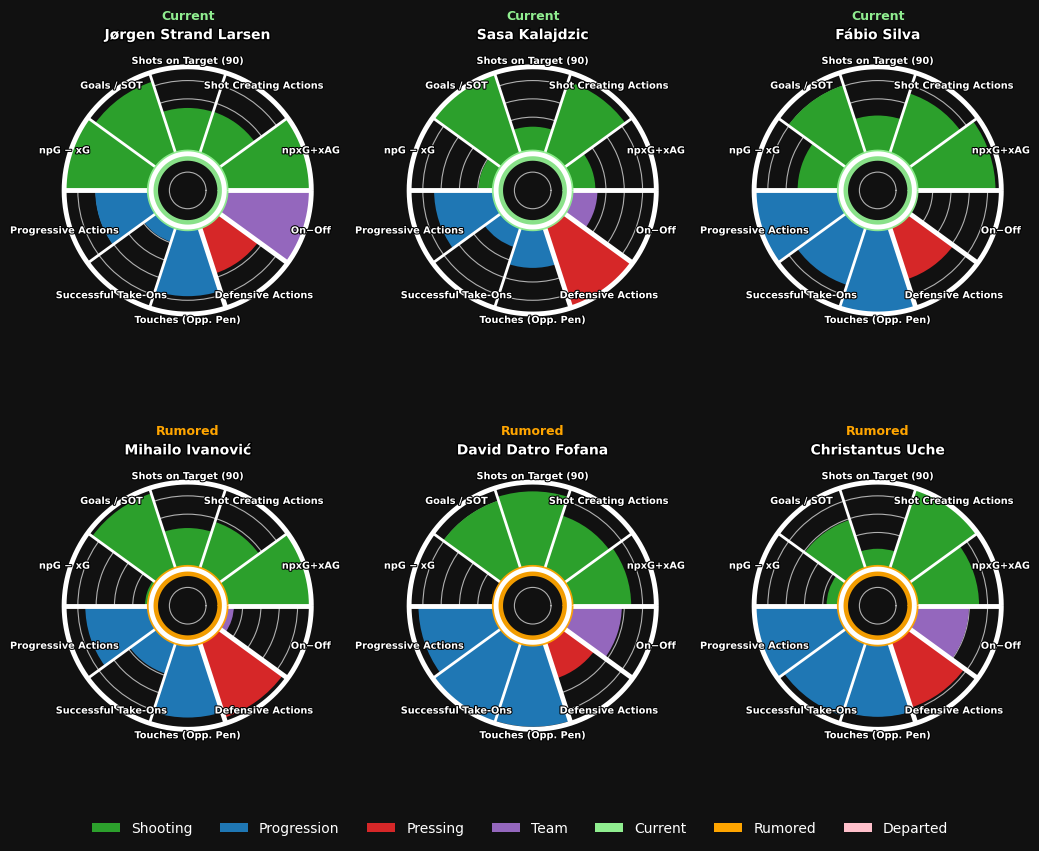

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

metrics = [
    'npxG+xAG', 'SCA', 'SOT90', 'GSOT', 'npG-xG',
    'PrgA', 'STO', 'TAP',
    'DA',
    'On-Off'
]

display_names = {
    'npxG+xAG': 'npxG+xAG',
    'SCA': 'Shot Creating Actions',
    'SOT90': 'Shots on Target (90)',
    'GSOT': 'Goals / SOT',
    'npG-xG': 'npG − xG',
    'PrgA': 'Progressive Actions',
    'STO': 'Successful Take-Ons',
    'TAP': 'Touches (Opp. Pen)',
    'DA': 'Defensive Actions',
    'On-Off': 'On−Off'
}

shooting  = ['npxG+xAG', 'SCA', 'SOT90', 'GSOT', 'npG-xG']
progress  = ['PrgA', 'STO', 'TAP']
pressing  = ['DA']
team      = ['On-Off']

FIG_BG = AX_BG = "#111111"
SEPARATOR_COLOR = "white"
SEP_THIN  = 2.0
SEP_THICK = 3.5

SHOOT_COLOR = "#2ca02c"
PROG_COLOR  = "#1f77b4"
PRESS_COLOR = "#d62728"
TEAM_COLOR  = "#9467bd"

def color_for_metric(m):
    if m in shooting:  return SHOOT_COLOR
    if m in progress:  return PROG_COLOR
    if m in pressing:  return PRESS_COLOR
    return TEAM_COLOR

wedge_colors = [color_for_metric(m) for m in metrics]

STATUS_COLORS = {"Current": "lightgreen", "Rumored": "orange", "Departed": "pink"}

VIS_MIN = 0.07      
FLOOR_ZEROES = False 

POS_FILTERS = ["ST", "CF", "FW"]
st_df = df[df["Position"].astype(str).str.upper().isin(POS_FILTERS)].copy()
players = st_df["Player"].astype(str).tolist()
if len(players) == 0:
    print("Note: No rows found with Position in", POS_FILTERS, "— using ALL rows instead.")
    st_df = df.copy()
    players = st_df["Player"].astype(str).tolist()
    if len(players) == 0:
        raise SystemExit("No players found.")

signed_metrics = ['npG-xG', 'On-Off']
nonneg_metrics = [m for m in metrics if m not in signed_metrics]

p90 = df[nonneg_metrics].apply(pd.to_numeric, errors='coerce').quantile(0.90).replace(0, np.nan)

def _signed_bounds(s):
    s = pd.to_numeric(s, errors='coerce').dropna()
    if s.empty:
        return 0.0, 1.0
    mn, mx = float(s.min()), float(s.max())
    rng = max(1e-9, mx - mn)
    return mn, rng

npGxG_min_all, npGxG_rng_all = _signed_bounds(df['npG-xG'] if 'npG-xG' in df.columns else pd.Series(dtype=float))
onoff_min_all, onoff_rng_all = _signed_bounds(df['On-Off'] if 'On-Off' in df.columns else pd.Series(dtype=float))

norm_df = st_df.copy()

for m in nonneg_metrics:
    if m in st_df.columns:
        denom = p90.get(m, np.nan)
        denom = 1.0 if (pd.isna(denom) or denom <= 0) else float(denom)
        norm_df[m] = (pd.to_numeric(st_df[m], errors='coerce') / denom).clip(0.0, 1.0)
    else:
        norm_df[m] = 0.0

if 'npG-xG' in st_df.columns:
    norm_df['npG-xG'] = ((pd.to_numeric(st_df['npG-xG'], errors='coerce') - npGxG_min_all) / npGxG_rng_all).clip(0.0, 1.0)
else:
    norm_df['npG-xG'] = 0.0

if 'On-Off' in st_df.columns:
    norm_df['On-Off'] = ((pd.to_numeric(st_df['On-Off'], errors='coerce') - onoff_min_all) / onoff_rng_all).clip(0.0, 1.0)
else:
    norm_df['On-Off'] = 0.0

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
width = 2*np.pi / len(metrics)
inner_radius = 0.35
outer_radius = inner_radius + 1.0
theta_circle = np.linspace(0, 2*np.pi, 720)

idx_shoot_end = len(shooting)
idx_prog_end  = len(shooting) + len(progress)
idx_press_end = len(shooting) + len(progress) + len(pressing)

status_raw = st_df["Status"].fillna("").astype(str).str.strip().str.lower()

def _status_label(s):
    if s == "left": return "Departed"
    if s == "rumor": return "Rumored"
    return "Current"

status_labels = status_raw.map(_status_label)
status_by_player = dict(zip(st_df["Player"], status_labels))
status_colors_by_player = {p: STATUS_COLORS[status_by_player[p]] for p in players}

n_players = len(players)
ncols = 3
nrows = int(np.ceil(n_players / ncols))

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, subplot_kw=dict(polar=True),
    figsize=(ncols * 3.5, nrows * 4.5)
)
axs = axs.flatten()

for i, name in enumerate(players):
    vals = norm_df.loc[norm_df['Player'] == name, metrics].values.flatten()
    vals = np.nan_to_num(vals, nan=0.0)

    if FLOOR_ZEROES:
        vals_plot = np.maximum(vals, VIS_MIN)
    else:
        vals_plot = np.where(vals > 0, np.maximum(vals, VIS_MIN), 0.0)

    ax = axs[i]
    ax.set_facecolor(AX_BG)
    ax.set_ylim(0, outer_radius)

    inner_circle_radius_overlay = inner_radius + 0.05
    scale = outer_radius - inner_circle_radius_overlay

    ax.bar(
        angles, vals_plot * scale, width=width, bottom=inner_circle_radius_overlay,
        align='edge', color=wedge_colors, zorder=2
    )

    for ang in angles:
        ax.plot([ang, ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THIN, color=SEPARATOR_COLOR, zorder=3, solid_capstyle='butt')

    for b_idx in [0, idx_shoot_end, idx_prog_end, idx_press_end]:
        b_ang = angles[b_idx]
        ax.plot([b_ang, b_ang], [inner_circle_radius_overlay, outer_radius],
                linewidth=SEP_THICK, color=SEPARATOR_COLOR, zorder=4, solid_capstyle='butt')

    ax.plot(theta_circle, np.full_like(theta_circle, outer_radius),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=5, clip_on=False, solid_capstyle='butt')

    for ang, lab in zip(angles + width/2, [display_names[m] for m in metrics]):
        txt = ax.text(
            ang, inner_radius + 1.065, lab,
            rotation=0, ha='center', va='center',
            fontsize=7, fontweight='bold', color='white', zorder=6
        )
        txt.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()
        ])

    status_ring_r = inner_radius + 0.035
    ax.plot(theta_circle, np.full_like(theta_circle, status_ring_r),
            color=status_colors_by_player[name], linewidth=8, zorder=9, solid_capstyle='butt', alpha=0.95)

    ax.plot(theta_circle, np.full_like(theta_circle, inner_circle_radius_overlay),
            color=SEPARATOR_COLOR, linewidth=SEP_THICK, zorder=10, clip_on=False, solid_capstyle='butt')

    ax.text(0.5, 1.18, status_by_player[name],
            transform=ax.transAxes, ha='center', va='bottom',
            fontsize=9, fontweight='bold', color=status_colors_by_player[name])
    title_text = ax.text(
        0.5, 1.10, name,
        transform=ax.transAxes, ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='white'
    )
    title_text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

    ax.set_xticks([])
    ax.set_thetagrids([])
    ax.set_yticklabels([])

last_used = len(players) - 1
for j in range(last_used + 1, len(axs)):
    axs[j].axis('off')

fig.patch.set_facecolor(FIG_BG)

legend_handles = [
    Patch(facecolor=SHOOT_COLOR, label="Shooting"),
    Patch(facecolor=PROG_COLOR,  label="Progression"),
    Patch(facecolor=PRESS_COLOR, label="Pressing"),
    Patch(facecolor=TEAM_COLOR,  label="Team"),
    Patch(facecolor=STATUS_COLORS["Current"],  label="Current"),
    Patch(facecolor=STATUS_COLORS["Rumored"],  label="Rumored"),
    Patch(facecolor=STATUS_COLORS["Departed"], label="Departed"),
]
leg = fig.legend(
    handles=legend_handles, loc='lower center', ncol=7,
    bbox_to_anchor=(0.5, 0.02), frameon=True
)
plt.setp(leg.get_texts(), color='white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.tight_layout(rect=[0, 0.06, 1, 1], h_pad=3.0)
plt.show()


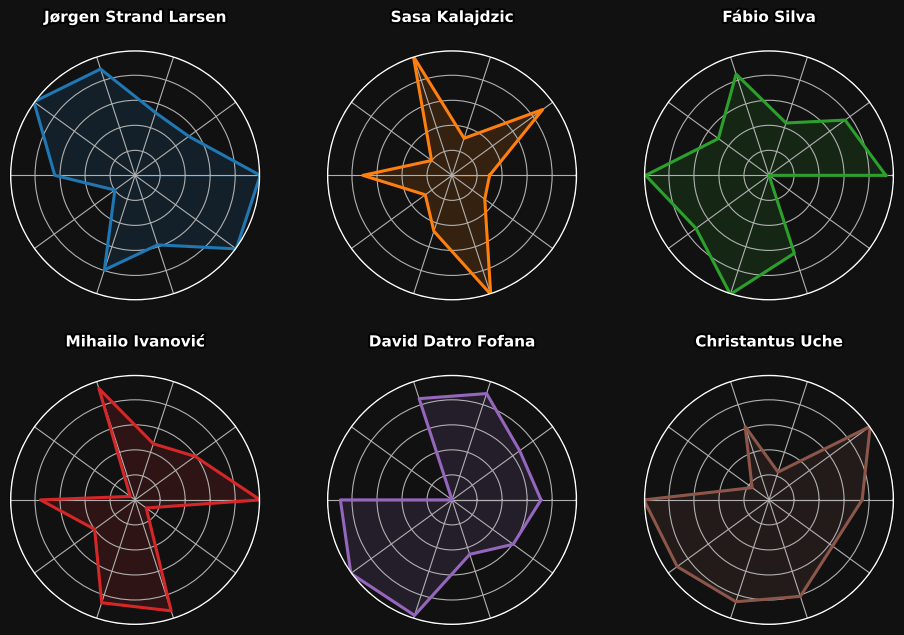

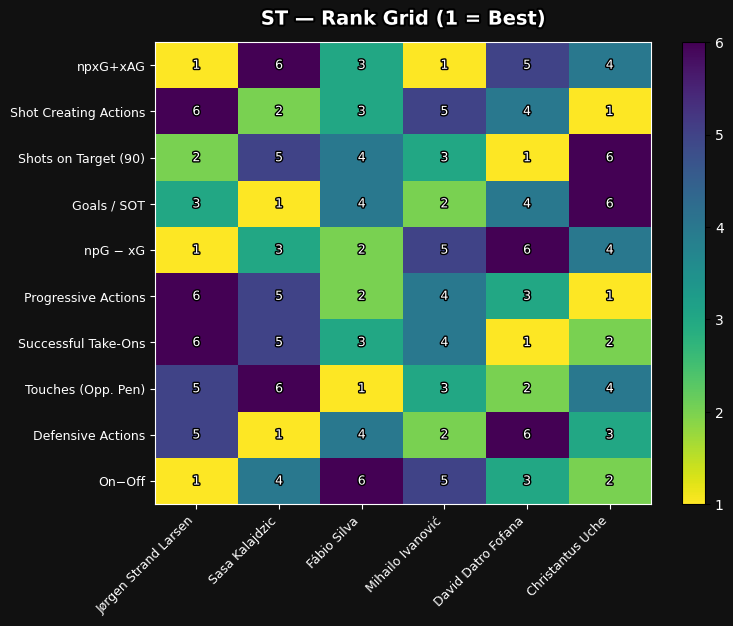

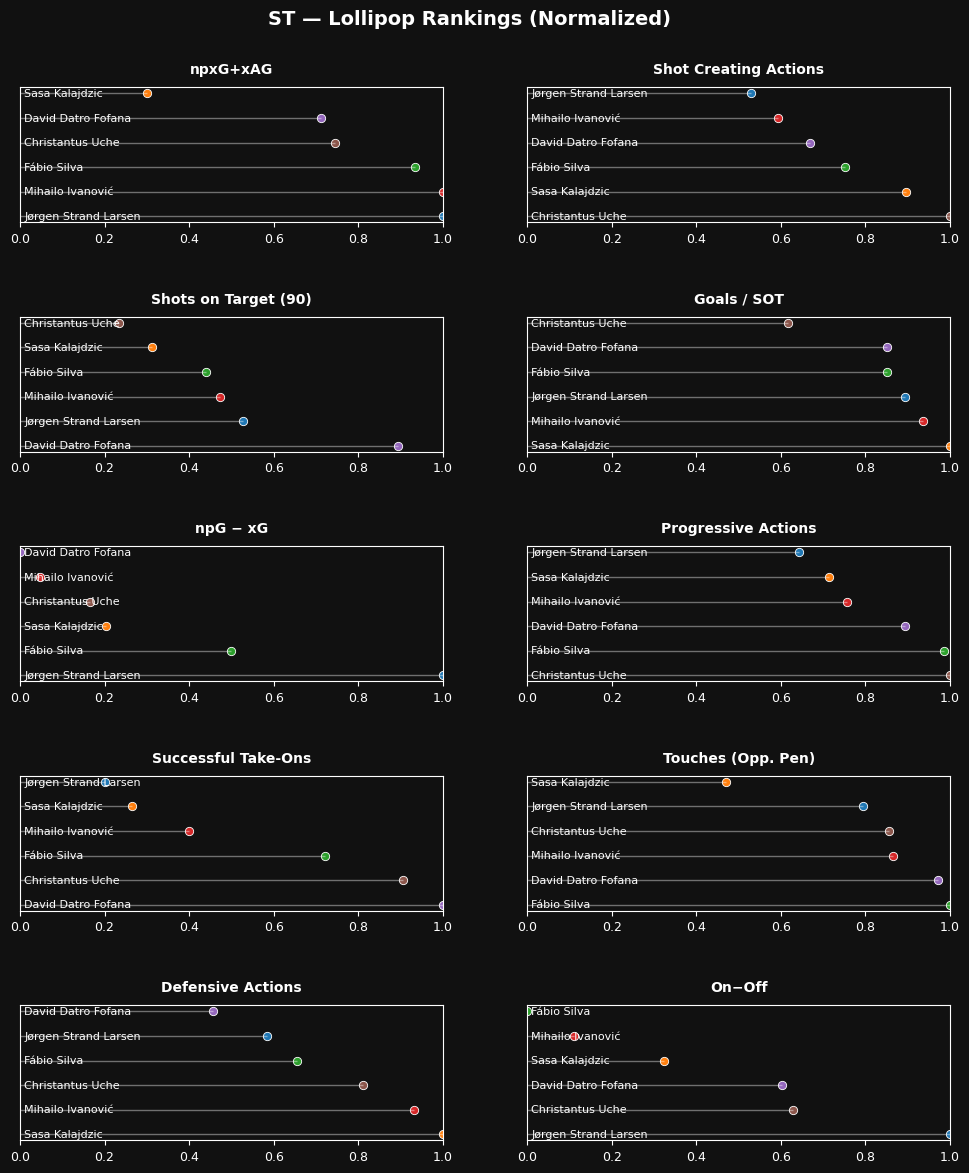

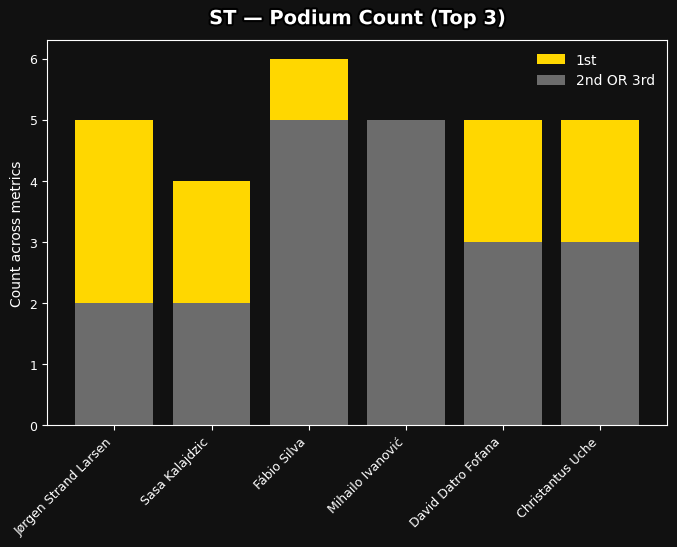

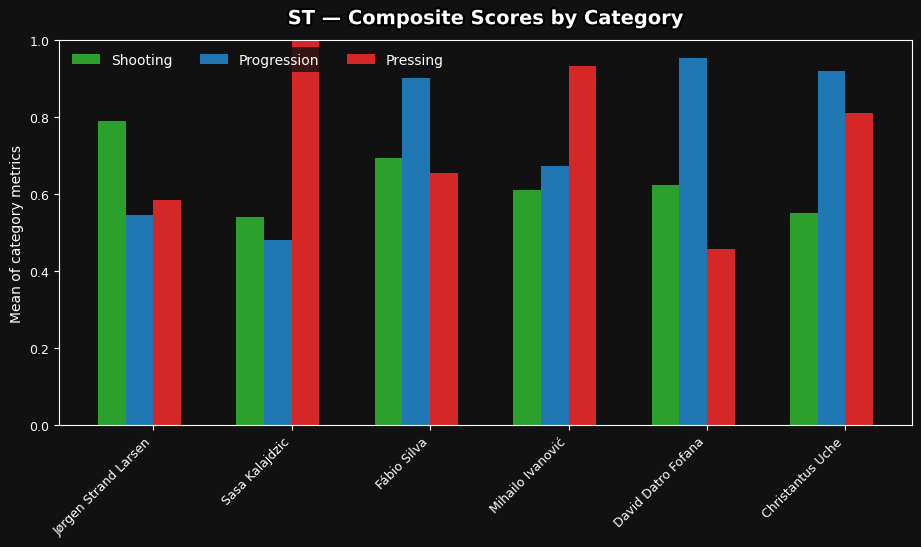

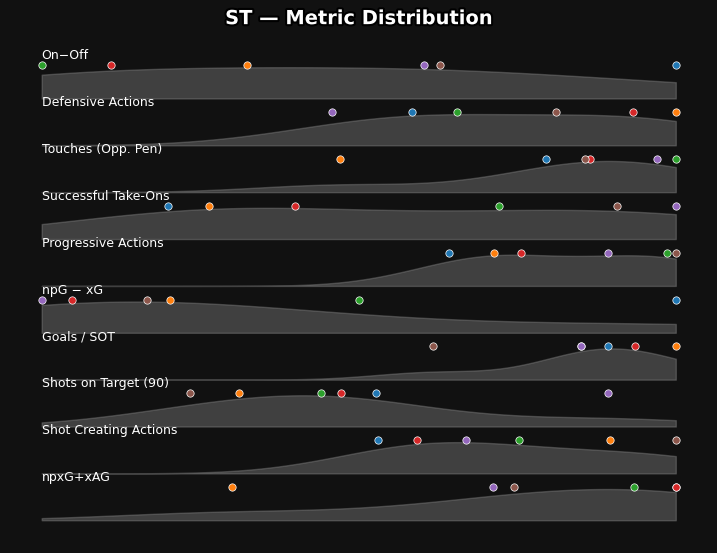

In [12]:
# ===================================
# FULLY-STYLED ST VIS TOOLKIT (DARK)
# ===================================
# IMPORTANT (expected from your ST prep):
#   - norm_df  (ST-only, normalized 0–1 with safe scaling for signed metrics like On-Off/npG-xG if present)
#   - metrics, display_names, players
#   - FIG_BG, AX_BG
#   - SHOOT_COLOR, PROG_COLOR, PRESS_COLOR, TEAM_COLOR
#
# This mirrors your CB toolkit but adapted to ST categories (Shooting/Progression/Pressing/Team)
# and keeps robust NaN/inf handling so ranking/plotting won't crash.

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from collections import defaultdict

# ---- category definitions for ST ----
shooting  = ['npxG+xAG', 'SCA', 'SOT90', 'GSOT', 'npG-xG']   # adjust to match your 'metrics'
progress  = ['PrgA', 'STO', 'TAP']
pressing  = ['DA']
team      = ['On-Off']

# ---------- helpers ----------
def _dark_fig_ax(size=(7,7)):
    fig = plt.figure(figsize=size)
    fig.patch.set_facecolor(FIG_BG)
    ax = plt.subplot(111)
    ax.set_facecolor(AX_BG)
    return fig, ax

def _style_axes(ax):
    ax.tick_params(colors='white', labelsize=9)
    for spine in ax.spines.values():
        spine.set_color('white')

def _title(ax, text, y=1.02, size=14):
    t = ax.set_title(text, color='white', fontsize=size, fontweight='bold', y=y)
    t.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground='black'),
        path_effects.Normal()
    ])

def _save(fig, name=None, pad=0.3):
    # If you also want files, uncomment the next line:
    # fig.savefig(name, dpi=200, bbox_inches="tight", facecolor=FIG_BG, pad_inches=pad)
    plt.show()
    plt.close(fig)

def _names_for_metrics(mets):
    return [display_names[m] for m in mets]

# Category composites (rows=players)
def _category_composites(M):
    S = M[shooting].mean(axis=1,   skipna=True) if set(shooting).issubset(M.columns)  else None
    P = M[progress].mean(axis=1,   skipna=True) if set(progress).issubset(M.columns)  else None
    R = M[pressing].mean(axis=1,   skipna=True) if set(pressing).issubset(M.columns)  else None
    T = M[team].mean(axis=1,       skipna=True) if set(team).issubset(M.columns)      else None
    return S, P, R, T

# Z-score per column (NaN-safe; NaNs stay NaN)
def _zscore(M):
    mu = M.mean(axis=0, skipna=True)
    sd = M.std(axis=0, ddof=0, skipna=True).replace(0, 1)
    return (M - mu) / sd

# consistent player color map
player_cmap = {p: plt.cm.tab10(i % 10) for i,p in enumerate(players)}

# Base matrices (players x metrics)
# M keeps NaNs for ranking logic; M_plot is NaN/inf-free for plotting
M = (
    norm_df.set_index('Player')[metrics]
    .reindex(players)
)
M = M.replace([np.inf, -np.inf], np.nan)
M_plot = M.fillna(0.0)

# ============================================
# 1) Z-score heatmap (players x metrics)
# ============================================
def vis_heatmap_zscore_st():
    mat = _zscore(M.copy()).fillna(0.0)  # show blanks as 0 for color mapping
    fig, ax = _dark_fig_ax((7,7))
    im = ax.imshow(mat.values, aspect='auto', cmap='coolwarm', vmin=-2.5, vmax=2.5)
    ax.set_yticks(range(len(players)))
    ax.set_yticklabels(players, color='white', fontsize=9)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(_names_for_metrics(metrics), rotation=45, ha='right', color='white', fontsize=8)
    _style_axes(ax)
    _title(ax, "ST — Metric Heatmap (z-score)")
    cbar = fig.colorbar(im)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "st_heatmap_zscore.png")

# ============================================
# 2) Beeswarm / strip by metric
# ============================================
def vis_beeswarm_st():
    fig, ax = _dark_fig_ax((7,7))
    y_positions = np.arange(len(metrics))
    for i, m in enumerate(metrics):
        xs = M[m].values
        finite = np.isfinite(xs)
        xs = xs[finite]
        pls = np.array(players)[finite]
        y = np.full_like(xs, y_positions[i], dtype=float) + (np.random.rand(len(xs))-0.5) * 0.25
        for x, yy, p in zip(xs, y, pls):
            ax.scatter(x, yy, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6, zorder=2)
    # means (skip NaNs)
    means = M.mean(axis=0, skipna=True).values
    ax.scatter(means, y_positions, s=80, facecolors='none', edgecolor='white', linewidth=1.4, zorder=3)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xlabel("Normalized value (0–1)", color='white')
    _style_axes(ax)
    _title(ax, "ST — Beeswarm by Metric (w/ means)")
    _save(fig, "st_beeswarm.png")

# ============================================
# 5) Radar small multiples (grid)
# ============================================
def vis_radar_small_multiples_st():
    n = len(players)
    cols = 3
    rows = math.ceil(n/cols)
    fig = plt.figure(figsize=(cols*3.2, rows*3.2))
    fig.patch.set_facecolor(FIG_BG)
    angles_p = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    th = np.linspace(0, 2*np.pi, 720)
    for i, p in enumerate(players, 1):
        ax = plt.subplot(rows, cols, i, polar=True)
        ax.set_facecolor(AX_BG); ax.set_ylim(0,1)
        vals = M_plot.loc[p].values  # NaNs→0
        ax.plot(np.append(angles_p, angles_p[0]), np.append(vals, vals[0]), color=player_cmap[p], linewidth=2.2)
        ax.fill_between(np.append(angles_p, angles_p[0]), 0, np.append(vals, vals[0]),
                        color=player_cmap[p], alpha=0.15)
        ax.set_xticks(angles_p); ax.set_yticklabels([]); ax.set_xticklabels([])
        ax.plot(th, np.full_like(th, 0), color='white', lw=3.5, alpha=1.0, zorder=5)
        ax.plot(th, np.full_like(th, 1), color='white', lw=2.0, alpha=1.0, zorder=5)
        t = ax.set_title(p, color='white', fontsize=11, y=1.08, fontweight='bold')
        t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'), path_effects.Normal()])
    plt.tight_layout(h_pad=3.0, w_pad=1.5)
    _save(fig, "st_radar_small_multiples.png", pad=0.2)

# ============================================
# 8) Rank grid (metric x player, numbers)
# ============================================
def vis_rank_grid_st():
    # Rank each metric column; NaNs get worst rank (= len(players))
    ranks = M.copy()
    for m in metrics:
        col = M[m]
        r = col.rank(ascending=False, method='min', na_option='bottom')  # NaNs to bottom if supported
        if r.isna().any():
            r = r.fillna(len(players))
        ranks[m] = r.astype(int)

    fig, ax = _dark_fig_ax((8,6))
    im = ax.imshow(ranks.values.T, aspect='auto', cmap='viridis_r')
    ax.set_yticks(range(len(metrics)))
    ax.set_yticklabels(_names_for_metrics(metrics), color='white', fontsize=9)
    ax.set_xticks(range(len(players)))
    ax.set_xticklabels(players, rotation=45, ha='right', color='white', fontsize=8)

    for i in range(len(players)):
        for j in range(len(metrics)):
            val = int(ranks.values[i, j])
            txt = ax.text(i, j, str(val), ha='center', va='center',
                          color='white', fontsize=9, zorder=3)
            txt.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
    _style_axes(ax)
    _title(ax, "ST — Rank Grid (1 = Best)")
    cbar = fig.colorbar(im)
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    _save(fig, "st_rank_grid.png")

# ============================================
# 9) Lollipop ranks per metric (multi-panel)
# ============================================
def vis_lollipop_ranks_st():
    r, c = 5, 2
    pages = math.ceil(len(metrics)/(r*c))
    for page in range(pages):
        fig = plt.figure(figsize=(c*6, r*2.6))
        fig.patch.set_facecolor(FIG_BG)
        for k in range(r*c):
            idx = page*(r*c)+k
            if idx >= len(metrics): break
            m = metrics[idx]
            ax = plt.subplot(r, c, k+1)
            ax.set_facecolor(AX_BG)

            s = M[m].dropna().sort_values(ascending=False)  # drop NaNs for clean order
            ax.hlines(y=np.arange(len(s)), xmin=0, xmax=s.values, color='white', lw=1, alpha=0.4)
            for i,(p,val) in enumerate(s.items()):
                ax.scatter(val, i, s=36, color=player_cmap[p], edgecolor='white', linewidth=0.6)
                ax.text(0.01, i, p, va='center', color='white', fontsize=8)
            ax.set_yticks([])
            ax.set_xlim(0,1)
            ax.set_title(display_names[m], color='white', fontsize=10, fontweight='bold', pad=10)
            _style_axes(ax)
        fig.suptitle("ST — Lollipop Rankings (Normalized)", y=0.98, color='white', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.92, hspace=0.7)
        _save(fig, f"st_lollipop_ranks_p{page+1}.png", pad=0.3)

# ============================================
# 10) Medal table (top1/top3 counts)
# ============================================
def vis_medal_table_st():
    counts_top1 = defaultdict(int)
    counts_top3 = defaultdict(int)
    for m in metrics:
        s = M[m].dropna().sort_values(ascending=False)
        if s.empty:
            continue
        counts_top1[s.index[0]] += 1
        for p in s.index[:3]:
            counts_top3[p] += 1

    fig, ax = _dark_fig_ax((8,5))
    x = np.arange(len(players))
    top1_list = np.array([counts_top1[p] for p in players])
    top3_list = np.array([counts_top3[p] for p in players])
    top3_only = top3_list - top1_list

    ax.bar(x, top1_list, bottom=top3_only, color="#ffd700", label="1st")
    ax.bar(x, top3_only, color="#aaaaaa", alpha=0.6, label="2nd OR 3rd")
    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylabel("Count across metrics", color='white')
    _style_axes(ax); _title(ax, "ST — Podium Count (Top 3)")
    leg = ax.legend(frameon=True)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "st_medal_table.png")

# ============================================
# 13) Composite score bars (by category)
# ============================================
def vis_composite_bars_st():
    S, P, R, T = _category_composites(M)
    fig, ax = _dark_fig_ax((11,5))
    x = np.arange(len(players))
    w = 0.2

    Sv = (S.values if hasattr(S, 'values') else np.zeros(len(players))) if S is not None else np.zeros(len(players))
    Pv = (P.values if hasattr(P, 'values') else np.zeros(len(players))) if P is not None else np.zeros(len(players))
    Rv = (R.values if hasattr(R, 'values') else np.zeros(len(players))) if R is not None else np.zeros(len(players))
    # Tv = (T.values if hasattr(T, 'values') else np.zeros(len(players))) if T is not None else np.zeros(len(players))

    ax.bar(x - 1.5*w, Sv, width=w, color=SHOOT_COLOR, label="Shooting")
    ax.bar(x - 0.5*w, Pv, width=w, color=PROG_COLOR,  label="Progression")
    ax.bar(x + 0.5*w, Rv, width=w, color=PRESS_COLOR, label="Pressing")
    # ax.bar(x + 1.5*w, Tv, width=w, color=TEAM_COLOR,  label="Team (On−Off)")

    ax.set_xticks(x); ax.set_xticklabels(players, rotation=45, ha='right', color='white')
    ax.set_ylim(0,1); ax.set_ylabel("Mean of category metrics", color='white')
    _style_axes(ax); _title(ax, "ST — Composite Scores by Category")
    leg = ax.legend(frameon=True, ncol=4)
    for txt in leg.get_texts(): txt.set_color('white')
    leg.get_frame().set_facecolor(FIG_BG); leg.get_frame().set_edgecolor("none")
    _save(fig, "st_composite_bars.png")

# ============================================
# 18) Metric ridge-like density (approx — small N)
# ============================================
def vis_ridgeline_like_st():
    try:
        from scipy.stats import gaussian_kde
    except Exception:
        print("scipy not available — skipping ridgeline-like.")
        return
    rows = len(metrics)
    fig, ax = _dark_fig_ax((9, rows*0.45 + 2))
    ax.set_axis_off()
    x = np.linspace(0,1,256)
    base_y = 0
    gap = 1.2
    for i, m in enumerate(metrics):
        vals = M[m].dropna().values
        # KDE can fail with <=1 unique value; handle safely:
        if len(vals) < 2 or len(np.unique(vals)) < 2:
            y = np.zeros_like(x)
        else:
            kde = gaussian_kde(vals, bw_method='scott')
            y = kde(x)
            if y.max() > 0:
                y = y / y.max()
        y = y*0.8
        ax.fill_between(x, base_y, base_y + y, color="#888888", alpha=0.4)

        # Scatter each player's value if present
        for p in players:
            v = M.at[p, m]
            if np.isfinite(v):
                ax.scatter(v, base_y + 0.85, s=28, color=player_cmap[p], edgecolor='white', linewidth=0.5, zorder=3)

        ax.text(0.0, base_y + 0.95, display_names[m], color='white', fontsize=9, va='bottom')
        base_y += gap
    _title(ax, "ST — Metric Distribution", y=1.02)
    _save(fig, "st_ridgeline_like.png", pad=0.2)

# =========================
# RUN EVERYTHING (ST)
# =========================
def run_all_st_visuals():
    # vis_heatmap_zscore_st()
    # vis_beeswarm_st()
    vis_radar_small_multiples_st()
    vis_rank_grid_st()
    vis_lollipop_ranks_st()
    vis_medal_table_st()
    vis_composite_bars_st()
    vis_ridgeline_like_st()

# call this to generate everything:
run_all_st_visuals()


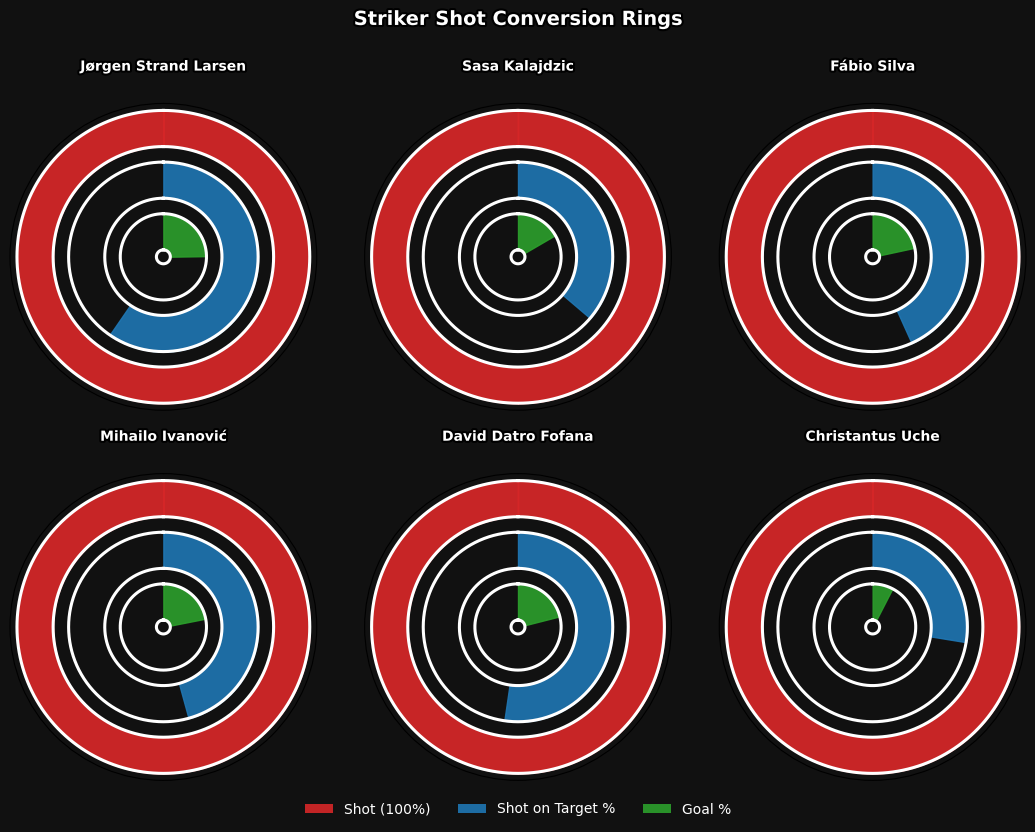

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

FIG_BG = "#111111"
AX_BG  = "#111111"
SHOT_COLOR = "#d62728"
SOT_COLOR  = "#1f77b4"
GOAL_COLOR = "#2ca02c"
RIM_COLOR  = "white"

FILE = "wolves_standard_stats_scouted.xlsx"
df = pd.read_excel(FILE)

POS_FILTERS = ["ST", "CF", "FW"]
st_df = df[df["Position"].astype(str).str.upper().isin(POS_FILTERS)].copy()
if st_df.empty:
    st_df = df.copy()

def clean_frac(s):
    x = pd.to_numeric(s, errors='coerce')
    if x.max(skipna=True) is not np.nan and x.max(skipna=True) > 1.01:
        x = x/100.0
    return x.clip(0.0,1.0)

st_df["_Shot"] = clean_frac(st_df["Shot"]).fillna(1.0)
st_df["_SOT"]  = clean_frac(st_df["Shot on Target"]).fillna(0.0)
st_df["_Goal"] = clean_frac(st_df["Goal"]).fillna(0.0)

players = st_df["Player"].astype(str).tolist()

r_outer, r_mid, r_in, band_w = 0.86, 0.66, 0.46, 0.14
sep_w = 2.2

n = len(players)
cols, rows = 3, int(np.ceil(n/3))
fig = plt.figure(figsize=(cols*3.6, rows*4.2))
fig.patch.set_facecolor(FIG_BG)

gt = fig.suptitle("Striker Shot Conversion Rings", y=0.995, color="white",
                  fontsize=14, fontweight='bold')
gt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                     path_effects.Normal()])

for i, p in enumerate(players,1):
    ax = plt.subplot(rows, cols, i, projection='polar')
    ax.set_facecolor(AX_BG)
    ax.set_theta_zero_location("N") 
    ax.set_theta_direction(-1)    
    ax.set_rticks([]); ax.set_xticks([]); ax.set_yticklabels([])

    theta = np.linspace(0,2*np.pi,721)
    for base_r,color in [(r_outer,SHOT_COLOR),(r_mid,AX_BG),(r_in,AX_BG)]:
        ax.fill_between(theta, base_r-band_w, base_r, color=color, alpha=0.25, zorder=1)
        ax.plot(theta, np.full_like(theta, base_r), color=RIM_COLOR, lw=sep_w, zorder=5)
        ax.plot(theta, np.full_like(theta, base_r-band_w), color=RIM_COLOR, lw=sep_w, zorder=5)

    v_shot = float(st_df.loc[st_df["Player"]==p,"_Shot"].iloc[0])
    v_sot  = float(st_df.loc[st_df["Player"]==p,"_SOT"].iloc[0])
    v_goal = float(st_df.loc[st_df["Player"]==p,"_Goal"].iloc[0])

    def arc(ax, frac, r_top, color, z=3):
        if frac<=0: return
        thetas = np.linspace(0,2*np.pi*frac, max(2,int(720*frac)))
        ax.fill_between(thetas, r_top-band_w, r_top, color=color, alpha=0.9, zorder=z)

    arc(ax, v_shot, r_outer, SHOT_COLOR, z=3)
    arc(ax, v_sot,  r_mid,   SOT_COLOR,  z=4)
    arc(ax, v_goal, r_in,    GOAL_COLOR, z=4)

    t = ax.set_title(p, color='white', fontsize=10, fontweight='bold', y=1.08)
    t.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                        path_effects.Normal()])

legend_handles = [
    Patch(facecolor=SHOT_COLOR, label="Shot (100%)", alpha=0.9),
    Patch(facecolor=SOT_COLOR,  label="Shot on Target %", alpha=0.9),
    Patch(facecolor=GOAL_COLOR, label="Goal %", alpha=0.9),
]
leg = fig.legend(handles=legend_handles, loc='lower center', ncol=3,
                 bbox_to_anchor=(0.5,0.02), frameon=True)
for txt in leg.get_texts(): txt.set_color('white')
leg.get_frame().set_facecolor(FIG_BG)
leg.get_frame().set_edgecolor("none")

plt.tight_layout(rect=[0,0.06,1,0.96], h_pad=5.2, w_pad=1)
plt.show()
